# Taks 1: Data scraping

The codes for Task 1:

**XJTLU**  
**Name:** Tianyu Ma  
**ID:** 1927930  

In [1]:
import re
import requests
import csv
from requests import RequestException


In [2]:
with open('books.csv','a',newline='',encoding='utf-8') as csvfile:
    writer=csv.writer(csvfile)
    writer.writerow(['title','reviews number','description','price','product type','category','availability'])


In [3]:
def save_book(book):
    with open('books.csv','a',newline='',encoding='utf-8') as csvfile:
        writer=csv.writer(csvfile)
        writer.writerow([book.get('title'),book.get('reviews number'),book.get('rating'),book.get('description'),book.get('price'),book.get('product type'),book.get('category'),book.get('availability')])


In [4]:
def get_page(url):
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:102.0) Gecko/20100101 Firefox/102.0'}
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response.text
        return None
    except RequestException:
        return None


In [6]:
def get_book_info(page_info):
    pattern_book_url = re.compile(
        '<li.*?>.*?<h3><a href="(.*?)" title.*?</h3>', re.S)
    book_urls = re.findall(pattern_book_url, page_info)
    print(book_urls)
    books_info=[]
    prefix='http://books.toscrape.com/catalogue/'
    for url in book_urls:
        url = prefix+url
        book_html = get_page(url)

        pattern_book_info = re.compile('<ul class="breadcrumb">.*?<li>.*?</li>.*?<li>.*?</li>.*?<li>.*?href=.*?>(.*?)</a>.*?</li>.*?product_main.*?<h1>(.*?)</h1>.*?price_color">Â£(.*?)</p>.*?product_description.*?<p>(.*?)</p>.*?Product Type.*?<td>(.*?)</td>.*?Availability.*?<td>(.*?)</td>.*?Number of reviews.*?<td>(.*?)</td>', re.S)
        book_info=re.findall(pattern_book_info, book_html)
        books_info.append(book_info)
    for info in books_info:
        for item in info:
            book={
            'title':item[1],
            'reviews number':item[6],
            'rating':item[],
            'description':item[3], 
            'price':item[2], 
            'product type':item[4],
            'category': item[0],
            'availability':item[5],
            }
            save_book(book)


SyntaxError: invalid syntax (808616621.py, line 20)

In [113]:
prefix = 'http://books.toscrape.com/catalogue/page-'

page_number=1
index=prefix+str(page_number)+'.html'


# Task 2

# Topic: When I enter into this website, what will influence my choice of books?

## Introduction
As a reader, sometimes I find it difficult to choose an appealing book. Generally speaking, the higher the rating of a book, the more valuable the book is to read. As a result, if there is a relationship between the rating and other factors, e.g. categories and price, it can be a reference for me to make a relevant good choice.

## Data Clean  

Since the amount of data is huge (1000), data cleaning is necessary to remove some useless content.

In [114]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)


In [115]:
dfbooks=pd.read_csv('books.csv')
dfbooks['rating']=dfbooks['rating'].map({'One':1,'Two':2,'Three':3,'Four':4,'Five':5})
dfbooks['availability']=dfbooks['availability'].str.extract('In stock \((.*?) available\)',expand=False)
dfbooks['availability']=dfbooks['availability'].apply(pd.to_numeric)
dfbooks.dtypes


KeyError: 'rating'

In [ ]:
dfbooks['reviews number'].value_counts()


0    998
Name: reviews number, dtype: int64

In [ ]:
dfbooks['product type'].value_counts()

Books    998
Name: product type, dtype: int64

Since the value of 'reviews number' is all 0 and Product type for all books is 'book', these attributes doh't make sense for data analysis. As a result, they are deleted.

In [ ]:
del dfbooks['reviews number']
del dfbooks['product type']
dfbooks.head()

,title,rating,description,price,category,availability
0,A Light in the Attic,3,It's hard to imagine a world without A Light i...,51.77,Poetry,22
1,Tipping the Velvet,1,"""Erotic and absorbing...Written with starling ...",53.74,Historical Fiction,20
2,Soumission,1,"Dans une France assez proche de la nÃ´tre, un ...",50.10,Fiction,20
3,Sharp Objects,4,"WICKED above her hipbone, GIRL across her hear...",47.82,Mystery,20
4,Sapiens: A Brief History of Humankind,5,From a renowned historian comes a groundbreaki...,54.23,History,20


In [ ]:
dfbooks['price_range']=dfbooks.price.apply(lambda x: int(int(x)/10)*10)
dfbooks.head()

,title,rating,description,price,category,availability,price_range
0,A Light in the Attic,3,It's hard to imagine a world without A Light i...,51.77,Poetry,22,50
1,Tipping the Velvet,1,"""Erotic and absorbing...Written with starling ...",53.74,Historical Fiction,20,50
2,Soumission,1,"Dans une France assez proche de la nÃ´tre, un ...",50.10,Fiction,20,50
3,Sharp Objects,4,"WICKED above her hipbone, GIRL across her hear...",47.82,Mystery,20,40
4,Sapiens: A Brief History of Humankind,5,From a renowned historian comes a groundbreaki...,54.23,History,20,50


In [ ]:
dfbooks.category.value_counts()

Default               151
Nonfiction            110
Sequential Art         75
Add a comment          67
Fiction                65
Young Adult            54
Fantasy                48
Romance                35
Mystery                32
Food and Drink         30
Childrens              29
Historical Fiction     26
Poetry                 19
Classics               18
History                18
Horror                 17
Womens Fiction         17
Science Fiction        16
Science                14
Music                  13
Business               12
Thriller               11
Travel                 11
Philosophy             11
Humor                  10
Autobiography           9
Art                     8
Psychology              7
Religion                7
Spirituality            6
Christian Fiction       6
New Adult               6
Sports and Games        5
Biography               5
Self Help               5
Health                  4
Christian               3
Politics                3
Contemporary

In order to avoid errors due to the tiny number of a certain type, only types of books with more than 15 books are counted, and books of 'default' and 'add a comment' types are not considered since the name makes no sense.

In [ ]:
dfbooks=dfbooks.groupby('category').filter(lambda x: len(x)>15)
dfbooks=dfbooks[(dfbooks.category!='Default') & (dfbooks.category!='Add a comment')]

### Methods  
In order to answer the question, first we need to obtain the distribution and mean of the rating of each category. As a result, I choose bar chart and box plot to illustrate it.

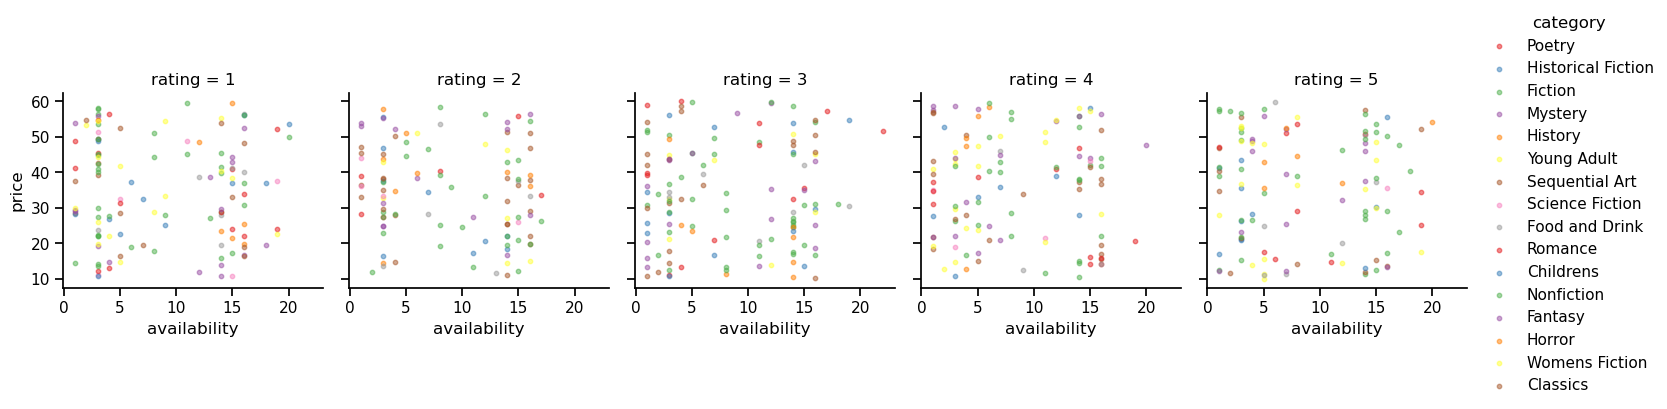

In [ ]:
g = sns.FacetGrid(dfbooks,col='rating',hue="category", palette="Set1")
g.map(plt.scatter,'availability','price',alpha=0.5, s=10)
g.add_legend()
plt.show()

From the scatter plot, there seems to be no clear correlation between ratings and prices, categories and availability. Further analysis is needed.

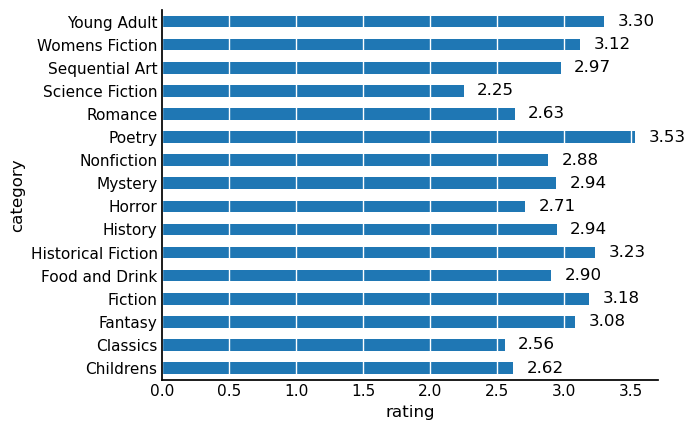

In [ ]:
sns.set_context("notebook")

avg_rating=dfbooks.groupby('category').rating.mean()

# plt.figure(figsize=(5, 6))
ax = plt.gca()
avg_rating.plot(kind="barh")
plt.grid(axis = 'x', color ='white', linestyle='-')
ax.tick_params(axis='both', which='both',length=0)

makes=avg_rating.index
rates=avg_rating.values
nums=np.arange(len(avg_rating))
for p, c, ch in zip(nums, makes, rates):
    plt.annotate(str("%.2f" % ch), xy=(ch + 0.1, p), va='center')

plt.xlabel('rating')
sns.despine() #
plt.show()

In terms of category, poetry receives the highest average score of 3.53, while science fiction is the lowest, which is 2.25.  
The top five rated book categories are Poetry, Young Adult, Historical Fiction, Fiction and Womens Fiction.

In [ ]:
dfbooks_short=dfbooks[(dfbooks['category']=='Poetry')|(dfbooks['category']=='Young Adult')|(dfbooks['category']=='Science Fiction')|(dfbooks['category']=='Historical Fiction')|(dfbooks['category']=='Fiction')|(dfbooks['category']=='Womens Fiction')]

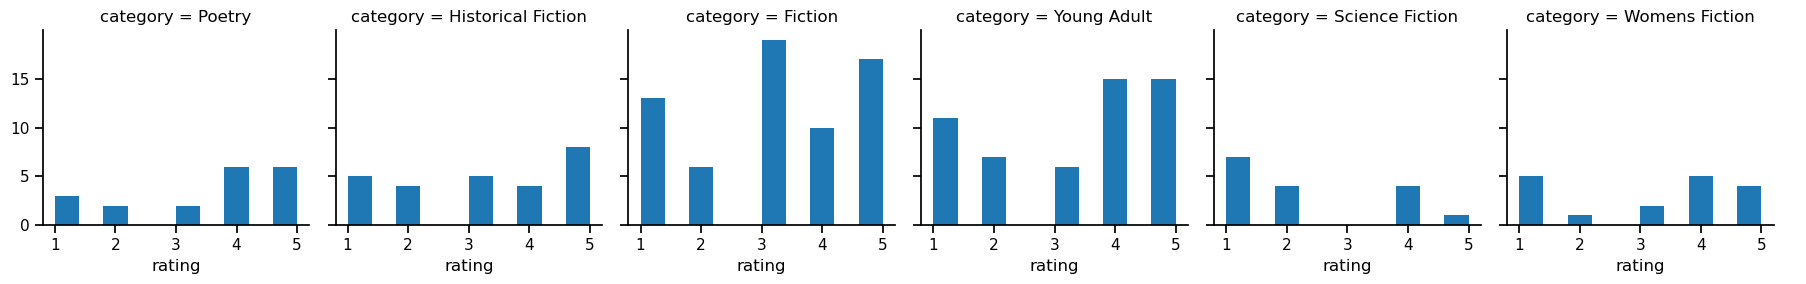

In [ ]:
g = sns.FacetGrid(dfbooks_short,col='category')
g.map(plt.hist,'rating')
g.add_legend()
plt.show()

<AxesSubplot:title={'center':'Womens Fiction'}, ylabel='rating'>

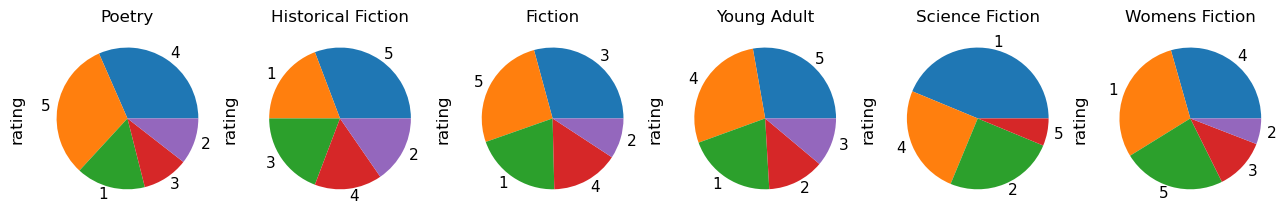

In [ ]:
fig, axs = plt.subplots(1,6, figsize = (16,4))
dfbooks[dfbooks['category']=='Poetry'].rating.value_counts().plot(kind='pie',ax=axs[0],title='Poetry')
dfbooks[dfbooks['category']=='Historical Fiction'].rating.value_counts().plot(kind='pie',ax=axs[1],title='Historical Fiction')
dfbooks[dfbooks['category']=='Fiction'].rating.value_counts().plot(kind='pie',ax=axs[2],title='Fiction')
dfbooks[dfbooks['category']=='Young Adult'].rating.value_counts().plot(kind='pie',ax=axs[3],title='Young Adult')
dfbooks[dfbooks['category']=='Science Fiction'].rating.value_counts().plot(kind='pie',ax=axs[4],title='Science Fiction')
dfbooks[dfbooks['category']=='Womens Fiction'].rating.value_counts().plot(kind='pie',ax=axs[5],title='Womens Fiction')

As the pie chart shows, despite the high percentage of 5 mark, 1 mark that makes up the largest proportion of the Fiction rating is probably the reason why Fiction has the lowest average rating, while the large proportion of 4 and 5 scores may be why the above categories get the top 5 average ratings. However, the number of people rating Poetry and Science Fiction is relatively small, and there are more people rating Fiction and Young Adult, so that it may have higher reference value

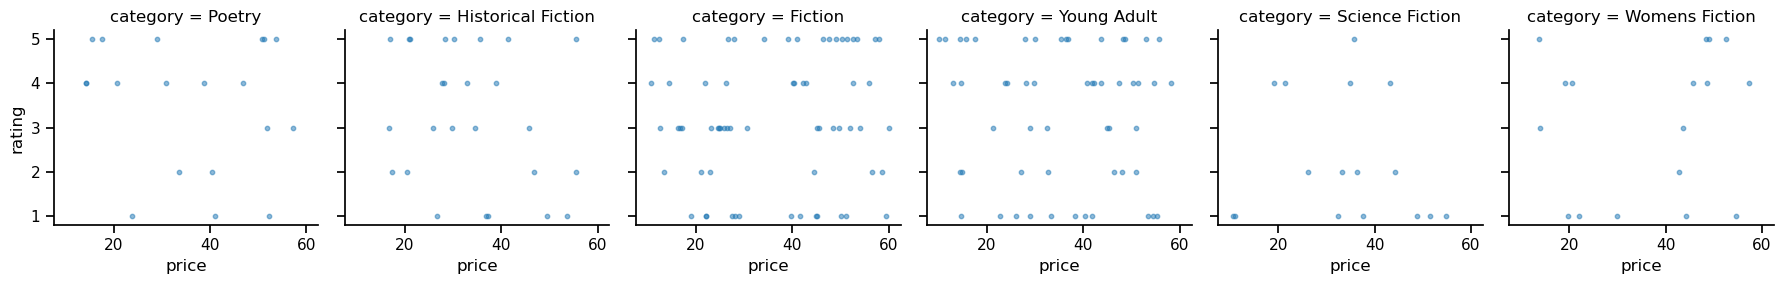

In [ ]:
g = sns.FacetGrid(dfbooks_short, col="category", palette="Set1")
g.map(plt.scatter, "price", "rating", alpha=0.5, s=10)
plt.show()

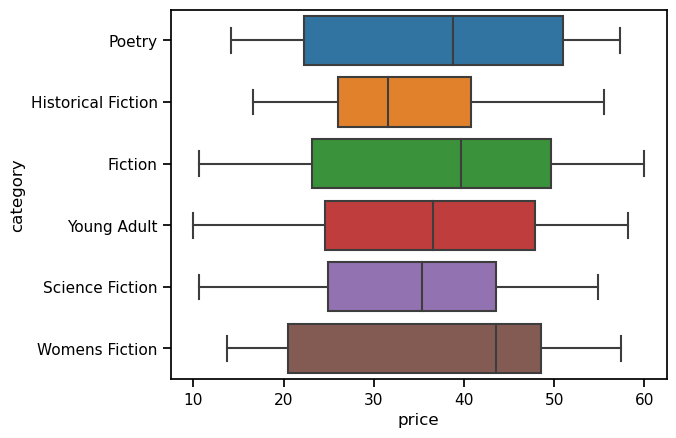

In [ ]:
sns.boxplot(y='category', x='price', data=dfbooks_short)
plt.show()

Price is another factor need to be considered when selecting books. As the scatter plot shows, it seems that there isn't an obvious connection between book price and rating. In addition, the box plot demonstrate that the prices of these six categories do not differ much. Women fiction has higher prices, while historical fiction and science fiction have a more concentrated price distribution.

# Conclusion  
In summary, price and rating will be important indicators for selecting books on the site. In my opinion, books with a high rate are more appealling, like Poetry and Young Adult books. Besides, The controversial remark of fiction may attract me to read it myself. Price is another point need to be taken into consideration. Women Fiction has relevant higher price so that it is probably not a good choice for me.